# Recurrent Vision Project (VS265, Fall 2022)

#### Team Members: Shafeeq Ibraheem, Hansen Lillemark, Jacob Yeung

#### This notebook is a basic CNN model which will train on the MNIST dataset. We will then compare its test accuracy on the MNIST test set and a noisy version of the MNIST test set. 
#### We are expecting the model to perform worse on the noisy test set, as the model has not been trained on noisy data.

In [1]:
# Import libraries for convolutional neural network and data processing
# We will use pytorch to create a convolutional neural network training on MNIST dataset. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Import the MNIST dataset
from torchvision import datasets, transforms

In [7]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

In [107]:
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms.ToTensor())
print(train_data)
print(train_data.data.size())
print(test_data)
print(test_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([10000, 28, 28])


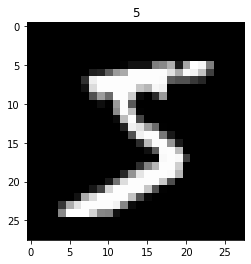

In [108]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

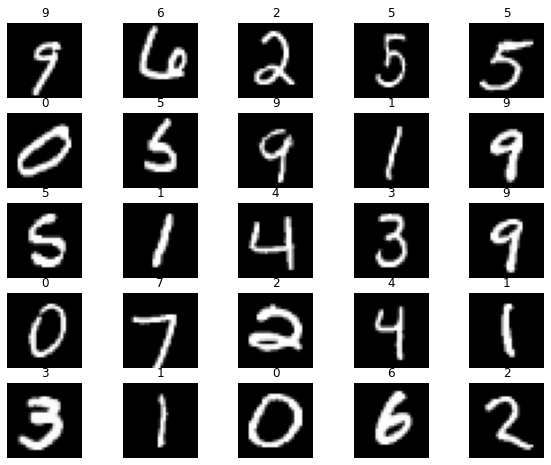

In [109]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [110]:
from torch.utils.data import DataLoader
# train_data.data = train_data.data.float().to(device)
# test_data.data = test_data.data.float().to(device)
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=512, 
                                          shuffle=True,),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=512, 
                                          shuffle=True,),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f99d868d610>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f99d868de50>}

In [111]:
loaders['train'].dataset.data.size(), type(loaders['train'].dataset.data)

(torch.Size([60000, 28, 28]), torch.Tensor)

In [178]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=8,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),      
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(8, 8, 3, 1, 1),     
            nn.ReLU(),                      
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.ReLU(),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(8 * 14 * 14, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # print(2, x.size())
        x = self.conv3(x)
        # print(3, x.size())
        # x = self.conv2(x)
        # x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [179]:
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [180]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [181]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [182]:
train_data.data[0].shape

torch.Size([28, 28])

In [183]:
cnn(train_data.data[0].unsqueeze(0).unsqueeze(0).float().to(device))

(tensor([[ 5.9066, -1.6764,  1.4987, -2.9731,  2.1673, -0.1181,  2.4851,  2.6619,
           0.6251, -2.4861]], device='cuda:2', grad_fn=<AddmmBackward0>),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1144, 0.1494, 0.0794]],
        device='cuda:2', grad_fn=<ViewBackward0>))

In [184]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)   # batch y
            # b_x = images
            # b_y = labels
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/118], Loss: 0.1168
Epoch [2/10], Step [100/118], Loss: 0.0707
Epoch [3/10], Step [100/118], Loss: 0.0521
Epoch [4/10], Step [100/118], Loss: 0.0192
Epoch [5/10], Step [100/118], Loss: 0.0471
Epoch [6/10], Step [100/118], Loss: 0.0175
Epoch [7/10], Step [100/118], Loss: 0.0772
Epoch [8/10], Step [100/118], Loss: 0.0157
Epoch [9/10], Step [100/118], Loss: 0.0265
Epoch [10/10], Step [100/118], Loss: 0.0401


In [164]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).sum().item()
        accuracy = correct / 10000 
        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.9862


In [185]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).sum().item()
        accuracy = correct / 10000 
        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.9837


In [186]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [187]:
actual_number = lbls[:10].numpy()
actual_number

array([4, 0, 2, 2, 8, 6, 1, 1, 9, 9])

In [188]:
test_output, last_layer = cnn(imgs[:10].to(device))
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [4 0 2 2 8 6 1 1 9 9]
Actual number: [4 0 2 2 8 6 1 1 9 9]


In [189]:
# Now we will add some gaussian noise to the test data and see if the performance is still good with the model which is not trained on noisy data.
# We will use the same model which we trained on clean data.

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

test_data_noisy = datasets.MNIST(root = 'data', train = False, download = True, 
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
]))


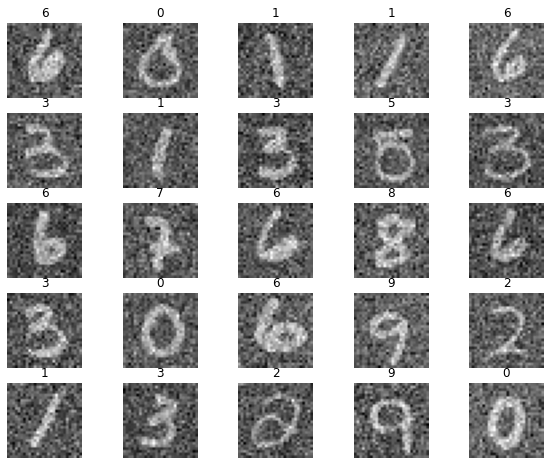

In [190]:
# View some of the noisy data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data_noisy), size=(1,)).item()
    img, label = test_data_noisy[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [191]:
loaders['test_data_noisy'] = torch.utils.data.DataLoader(test_data_noisy, 
                                          batch_size=10000, 
                                          shuffle=False, 
                                          num_workers=1)
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f99d868d610>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f99d868de50>,
 'test_data_noisy': <torch.utils.data.dataloader.DataLoader at 0x7f99545ff890>}

In [193]:
def test_noisy():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test_data_noisy']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
        accuracy = correct / 10000 
        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)
    
    pass
test_noisy()

Test Accuracy of the model on the 10000 test images: 0.7102
